In [1]:
import numpy as np
from typing import Generator
from itertools import product

def __pad_left_right(window_size: int, padding: int | str | tuple[int, int]) -> tuple[int, int]:
    """
    Computes the left and right padding for a convolution operation given the window size and padding.

    Args:
        window_size: the size of the sliding window
        padding: the amount of padding to add to the beginning and end of the array. Can be an integer, string, or tuple of integers.
            If padding is an integer, the same padding is applied to the beginning and end of the array.
            If padding is a string, it must be one of 'VALID', 'SAME', or 'FULL'.
                'VALID' indicates that no padding is applied.
                'SAME' indicates that the padding is chosen so that the output is the same size as the input.
                'FULL' indicates that the padding is equal to the window size minus 1.
            If padding is a tuple of integers, it must contain two integers representing the left and right padding.

    Returns:
        A tuple of two integers representing the left and right padding.
    """
    if isinstance(padding, (int, str)):
        if padding == 'VALID' or padding == 'valid':
            padding_left = 0
            padding_right = 0
        elif padding == 'SAME' or padding == 'same':
            if not window_size%2:
                padding_left = max(window_size // 2, 0)
                padding_right = padding_left - 1
            else:
                padding_left = (window_size - 1) // 2
                padding_right = padding_left
        elif padding == 'FULL' or padding == 'full':
            padding_left = window_size - 1
            padding_right = window_size - 1
        else:
            padding_left, padding_right = padding, padding

        assert padding_left >= 0 and padding_right >= 0, 'Padding can not be less than 0'
        assert padding_left < window_size and padding_right < window_size, 'Padding can not be greater than window_size'

    else:
        padding_left, padding_right = padding

    return padding_left, padding_right


def compute_output_shape(shape: tuple[int, ...], kernel_size: tuple[int, ...], paddings: int | tuple[int, ...] = 0, strides: int | tuple[int, ...] = 1) -> tuple[int, ...]:
    """
    Computes the shape of the output tensor of a convolution operation given the shape of the input tensor, kernel size, padding, and stride.

    Args:
        shape: a tuple of integers representing the shape of the input tensor
        kernel_size: a tuple of integers representing the size of the kernel in each dimension
        paddings: the amount of padding to add to the beginning and end of the input tensor in each dimension (default is 0)
        strides: the number of indices to skip when moving the kernel in each dimension (default is 1)

    Returns:
        A tuple of integers representing the shape of the output tensor.
    """
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size,)
    if isinstance(paddings, (int, str)):
        paddings = [paddings for _ in range(len(kernel_size))]
    paddings = [__pad_left_right(window_size, padding) for window_size, padding in zip(kernel_size, paddings)]
    if isinstance(strides, (int, str)):
        strides = [strides for _ in range(len(kernel_size))]

    output_shape = []
    for dim, k, (p_left, p_right), s in zip(shape, kernel_size, paddings, strides):
        output_dim = (dim + (p_left + p_right) - k) // s + 1
        output_shape.append(output_dim)
    return tuple(output_shape + [1 for _ in range(len(shape) - len(kernel_size))])


def conv_indices_generator(
    array_len: int,
    window_size: int,
    padding: int | str | tuple[int, int] = 0,
    stride: int = 1
) -> Generator[int | tuple[int, int], None, None]:
    """
    Generates indices for convolution of an array of a certain length with a sliding window.

    Args:
        array_len: the length of the array that the convolution is being applied to
        window_size: the size of the sliding window
        padding: the amount of padding to add to the beginning and end of the array (default is 0)
        stride: the number of indices to skip when moving the window (default is 1)

    Yields:
        A tuple of two integers representing the indices of the array elements in the current window position.
    """
    assert window_size > 0, 'Sliding window can not be less or equal to 0'
    assert stride > 0, 'Stride can not be less or equal to 0'
    padding_left, padding_right = __pad_left_right(window_size, padding)

    for i in range(0, array_len + padding_right, stride):
        from_ = min(array_len - 1, max(i-padding_left, 0))

        if array_len + padding_right - from_ < window_size:
            break

        to = max(min(array_len - 1, i - padding_left + window_size - 1), 0)

        if from_ != to:
            yield from_, to
        else:
            yield from_


def compute_kernel_coords(kernel_size: int, *coords: slice) -> tuple[slice, ...]:
    """
    Computes the kernel coordinates for a convolution operation given the kernel size and coordinates.

    Args:
        kernel_size: the size of the kernel
        *coords: the coordinates to be transformed. Should be slice objects.

    Returns:
        A tuple of slice objects representing the transformed coordinates.
    """
    out = list()
    for coord in coords:
        if coord == slice(0, None, None):
            out.append(coord)
        else:
            dist = abs(coord.stop - coord.start)
            if coord.start == 0:
                out.append(slice(-dist, None))
            else:
                out.append(slice(None, dist))

    return tuple(out)


def conviter(
    shape: tuple[int, int],
    kernel_size: tuple[int, ...],
    paddings: int | tuple[int, ...] = 0,
    strides: int | tuple[int, ...] = 1
) -> Generator[slice | tuple[slice], None, None]:
    """
    Generates indices for convolution of an array of a certain shape with a sliding window in n-dimensional space.

    Args:
        shape: a tuple of integers representing the shape of the array that the convolution is being applied to
        kernel_size: a tuple of integers representing the size of the sliding window in each dimension
        paddings: the amount of padding to add to the beginning and end of the array in each dimension (default is 0)
        strides: the number of indices to skip when moving the window in each dimension (default is 1)

    Yields:
        A tuple of integers representing the indices of the array elements in the current window position in n-dimensional space.
    """
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size,)
    assert len(kernel_size) <= len(shape), 'It is not possible to perform convolution with a kernel of a higher dimension than the data'

    if isinstance(paddings, (int, str)):
        paddings = [paddings for _ in range(len(kernel_size))]
    assert len(paddings) == len(kernel_size), 'Number of paddings must be consistent with the dimensionality of the kernel'

    if isinstance(strides, (int, str)):
        strides = [strides for _ in range(len(kernel_size))]
    assert len(strides) == len(kernel_size), 'Number of strides must be consistent with the dimensionality of the kernel'

    whole_axis = (0, None)
    plug = [whole_axis for _ in range(len(shape) - len(kernel_size))]
    out_plug = [0 for _ in range(len(plug))]
    conv_indices = [[indices if isinstance(indices, tuple) else (indices,) for indices in conv_indices_generator(*conv_args)] for conv_args in zip(shape, kernel_size, paddings, strides)]

    for indices, out_indices in zip(zip(product(*conv_indices)), zip(product(*[range(len(conv_i)) for conv_i in conv_indices]))):
        conv_out = list(indices[0]) + plug
        out = list(out_indices[0]) + out_plug
        conv_out = tuple(slice(ax[0], ax[-1]+1) if ax[-1] != None else slice(ax[0], ax[-1]) for ax in conv_out)

        if len(conv_out) == 1:
            yield conv_out[0], tuple(out), compute_kernel_coords(kernel_size, conv_out[0])
        else:
            yield conv_out, tuple(out), compute_kernel_coords(kernel_size, *conv_out)


def align_kernel(data: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    Aligns the kernel of the convolution with the shape of the data.

    Args:
        data: a numpy array representing the data
        kernel: a numpy array representing the kernel

    Returns:
        A numpy array representing the aligned kernel.
    """
    free_dims = [data.shape[j] for j in range(len(kernel.shape), len(data.shape))]
    new_kernel = kernel.copy()
    if free_dims:
        for free_dim in free_dims:
            new_kernel = np.array([new_kernel for _ in range(free_dim)])
            new_kernel = np.transpose(new_kernel, list(range(len(new_kernel.shape))[1:]) + [0])
    return new_kernel



In [278]:
for i in conv_indices_generator(10, 3, 2, 1):
    print(i)

0
(0, 1)
(0, 2)
(1, 3)
(2, 4)
(3, 5)
(4, 6)
(5, 7)
(6, 8)
(7, 9)
(8, 9)
9


In [279]:
for i in conviter(shape=(10, 10), kernel_size=(3, 2), paddings='full'):
    # slice of data, corresponding slice of output, slice of kernel
    print(i)

((slice(0, 1, None), slice(0, 1, None)), (0, 0), (slice(-1, None, None), slice(-1, None, None)))
((slice(0, 1, None), slice(0, 2, None)), (0, 1), (slice(-1, None, None), slice(-2, None, None)))
((slice(0, 1, None), slice(1, 3, None)), (0, 2), (slice(-1, None, None), slice(-2, None, None)))
((slice(0, 1, None), slice(2, 4, None)), (0, 3), (slice(-1, None, None), slice(-2, None, None)))
((slice(0, 1, None), slice(3, 5, None)), (0, 4), (slice(-1, None, None), slice(-2, None, None)))
((slice(0, 1, None), slice(4, 6, None)), (0, 5), (slice(-1, None, None), slice(-2, None, None)))
((slice(0, 1, None), slice(5, 7, None)), (0, 6), (slice(-1, None, None), slice(-2, None, None)))
((slice(0, 1, None), slice(6, 8, None)), (0, 7), (slice(-1, None, None), slice(-2, None, None)))
((slice(0, 1, None), slice(7, 9, None)), (0, 8), (slice(-1, None, None), slice(-2, None, None)))
((slice(0, 1, None), slice(8, 10, None)), (0, 9), (slice(-1, None, None), slice(-2, None, None)))
((slice(0, 1, None), slice(9,

In [291]:
X = np.arange(0, 100)

for slice_, out_coords, _ in conviter(X.shape, kernel_size=10, strides=10, paddings=5):
    print(X[slice_], out_coords)

[0 1 2 3 4] (0,)
[ 5  6  7  8  9 10 11 12 13 14] (1,)
[15 16 17 18 19 20 21 22 23 24] (2,)
[25 26 27 28 29 30 31 32 33 34] (3,)
[35 36 37 38 39 40 41 42 43 44] (4,)
[45 46 47 48 49 50 51 52 53 54] (5,)
[55 56 57 58 59 60 61 62 63 64] (6,)
[65 66 67 68 69 70 71 72 73 74] (7,)
[75 76 77 78 79 80 81 82 83 84] (8,)
[85 86 87 88 89 90 91 92 93 94] (9,)
[95 96 97 98 99] (10,)


In [295]:
X = np.arange(0, 100)

for slice_ , out_coords, _ in conviter(X.shape, kernel_size=10, strides=5, paddings=5):
    print(X[slice_], out_coords)

[0 1 2 3 4] (0,)
[0 1 2 3 4 5 6 7 8 9] (1,)
[ 5  6  7  8  9 10 11 12 13 14] (2,)
[10 11 12 13 14 15 16 17 18 19] (3,)
[15 16 17 18 19 20 21 22 23 24] (4,)
[20 21 22 23 24 25 26 27 28 29] (5,)
[25 26 27 28 29 30 31 32 33 34] (6,)
[30 31 32 33 34 35 36 37 38 39] (7,)
[35 36 37 38 39 40 41 42 43 44] (8,)
[40 41 42 43 44 45 46 47 48 49] (9,)
[45 46 47 48 49 50 51 52 53 54] (10,)
[50 51 52 53 54 55 56 57 58 59] (11,)
[55 56 57 58 59 60 61 62 63 64] (12,)
[60 61 62 63 64 65 66 67 68 69] (13,)
[65 66 67 68 69 70 71 72 73 74] (14,)
[70 71 72 73 74 75 76 77 78 79] (15,)
[75 76 77 78 79 80 81 82 83 84] (16,)
[80 81 82 83 84 85 86 87 88 89] (17,)
[85 86 87 88 89 90 91 92 93 94] (18,)
[90 91 92 93 94 95 96 97 98 99] (19,)
[95 96 97 98 99] (20,)


In [296]:
for i, (slice_, out_coords, kernel_coords) in enumerate(conviter(X.shape, kernel_size=10, paddings='same')):
    print(i, X[slice_], out_coords, kernel_coords)

0 [0 1 2 3 4] (0,) (slice(-5, None, None),)
1 [0 1 2 3 4 5] (1,) (slice(-6, None, None),)
2 [0 1 2 3 4 5 6] (2,) (slice(-7, None, None),)
3 [0 1 2 3 4 5 6 7] (3,) (slice(-8, None, None),)
4 [0 1 2 3 4 5 6 7 8] (4,) (slice(-9, None, None),)
5 [0 1 2 3 4 5 6 7 8 9] (5,) (slice(-10, None, None),)
6 [ 1  2  3  4  5  6  7  8  9 10] (6,) (slice(-10, None, None),)
7 [ 2  3  4  5  6  7  8  9 10 11] (7,) (slice(-10, None, None),)
8 [ 3  4  5  6  7  8  9 10 11 12] (8,) (slice(-10, None, None),)
9 [ 4  5  6  7  8  9 10 11 12 13] (9,) (slice(-10, None, None),)
10 [ 5  6  7  8  9 10 11 12 13 14] (10,) (slice(-10, None, None),)
11 [ 6  7  8  9 10 11 12 13 14 15] (11,) (slice(-10, None, None),)
12 [ 7  8  9 10 11 12 13 14 15 16] (12,) (slice(-10, None, None),)
13 [ 8  9 10 11 12 13 14 15 16 17] (13,) (slice(-10, None, None),)
14 [ 9 10 11 12 13 14 15 16 17 18] (14,) (slice(-10, None, None),)
15 [10 11 12 13 14 15 16 17 18 19] (15,) (slice(-10, None, None),)
16 [11 12 13 14 15 16 17 18 19 20] (16,) (s

In [297]:
X = np.random.random((10, 20, 30, 40))

for (ax1, ax2, ax3, ax4), (x, y, z, k), _ in conviter(X.shape, kernel_size=(2, 4, 5), strides=(1, 4, 2), paddings=(1, 3, 1)):
    print(
        f'{ax1.start}:{ax1.stop}, '
        f'{ax2.start}:{ax2.stop}, '
        f'{ax3.start}:{ax3.stop}, '
        f'{ax4.start}:{ax4.stop} \t',
        X[
            ax1,
            ax2,
            ax3,
            ax4,
        ].shape,
        [x, y, z, k]
    )

0:1, 0:1, 0:4, 0:None 	 (1, 1, 4, 40) [0, 0, 0, 0]
0:1, 0:1, 1:6, 0:None 	 (1, 1, 5, 40) [0, 0, 1, 0]
0:1, 0:1, 3:8, 0:None 	 (1, 1, 5, 40) [0, 0, 2, 0]
0:1, 0:1, 5:10, 0:None 	 (1, 1, 5, 40) [0, 0, 3, 0]
0:1, 0:1, 7:12, 0:None 	 (1, 1, 5, 40) [0, 0, 4, 0]
0:1, 0:1, 9:14, 0:None 	 (1, 1, 5, 40) [0, 0, 5, 0]
0:1, 0:1, 11:16, 0:None 	 (1, 1, 5, 40) [0, 0, 6, 0]
0:1, 0:1, 13:18, 0:None 	 (1, 1, 5, 40) [0, 0, 7, 0]
0:1, 0:1, 15:20, 0:None 	 (1, 1, 5, 40) [0, 0, 8, 0]
0:1, 0:1, 17:22, 0:None 	 (1, 1, 5, 40) [0, 0, 9, 0]
0:1, 0:1, 19:24, 0:None 	 (1, 1, 5, 40) [0, 0, 10, 0]
0:1, 0:1, 21:26, 0:None 	 (1, 1, 5, 40) [0, 0, 11, 0]
0:1, 0:1, 23:28, 0:None 	 (1, 1, 5, 40) [0, 0, 12, 0]
0:1, 0:1, 25:30, 0:None 	 (1, 1, 5, 40) [0, 0, 13, 0]
0:1, 1:5, 0:4, 0:None 	 (1, 4, 4, 40) [0, 1, 0, 0]
0:1, 1:5, 1:6, 0:None 	 (1, 4, 5, 40) [0, 1, 1, 0]
0:1, 1:5, 3:8, 0:None 	 (1, 4, 5, 40) [0, 1, 2, 0]
0:1, 1:5, 5:10, 0:None 	 (1, 4, 5, 40) [0, 1, 3, 0]
0:1, 1:5, 7:12, 0:None 	 (1, 4, 5, 40) [0, 1, 4, 0]
0:1, 1

In [298]:
compute_output_shape(X.shape, kernel_size=(2, 4, 5), strides=(1, 4, 2), paddings=(1, 3, 1))

(11, 6, 14, 1)

In [299]:
for i, ax in enumerate(conviter((8, 10), kernel_size=(2, 4), strides=(1, 4), paddings=(1, 2))):
    print(i, ax)

0 ((slice(0, 1, None), slice(0, 2, None)), (0, 0), (slice(-1, None, None), slice(-2, None, None)))
1 ((slice(0, 1, None), slice(2, 6, None)), (0, 1), (slice(-1, None, None), slice(-4, None, None)))
2 ((slice(0, 1, None), slice(6, 10, None)), (0, 2), (slice(-1, None, None), slice(-4, None, None)))
3 ((slice(0, 2, None), slice(0, 2, None)), (1, 0), (slice(-2, None, None), slice(-2, None, None)))
4 ((slice(0, 2, None), slice(2, 6, None)), (1, 1), (slice(-2, None, None), slice(-4, None, None)))
5 ((slice(0, 2, None), slice(6, 10, None)), (1, 2), (slice(-2, None, None), slice(-4, None, None)))
6 ((slice(1, 3, None), slice(0, 2, None)), (2, 0), (slice(-2, None, None), slice(-2, None, None)))
7 ((slice(1, 3, None), slice(2, 6, None)), (2, 1), (slice(-2, None, None), slice(-4, None, None)))
8 ((slice(1, 3, None), slice(6, 10, None)), (2, 2), (slice(-2, None, None), slice(-4, None, None)))
9 ((slice(2, 4, None), slice(0, 2, None)), (3, 0), (slice(-2, None, None), slice(-2, None, None)))
10 ((sl

In [300]:
compute_output_shape(
    (8, 10),
    kernel_size=(2, 4),
    strides=(1, 4),
    paddings=(1, 2)
)

(9, 3)

In [301]:
align_kernel(np.random.random((10, 20, 30, 40)), np.random.random((4))).shape

(4, 20, 30, 40)

In [303]:
kern = np.random.random((5, 2, 3))
X = np.random.random((15, 10, 20, 20, 20))
kern_aligned = align_kernel(X, kern)
paddings = (3, 1, 2)
strides = (3, 5, 4)
out = np.zeros(compute_output_shape(X.shape, kern.shape, paddings, strides))

for (p1, p2, p3, p4, p5), (q1, q2, q3, q4, q5), (k1, k2, k3, k4, k5) in conviter(X.shape, kern.shape, paddings, strides):
    out[q1, q2, q3, q4, q5] = (X[p1, p2, p3, p4, p5]*kern_aligned[k1, k2, k3, k4, k5]).sum()

In [304]:
out.shape

(6, 3, 6, 1, 1)

In [305]:
X = np.random.random((300, 501, 204))
kern = np.random.random((1, 204))

outs = list()
for x in X:
    kern_aligned = align_kernel(x, kern)
    out = np.zeros(compute_output_shape(x.shape, kern.shape))
    for (p1, p2), (q1, q2), (k1, k2) in conviter(x.shape, kern.shape):
        out[q1, q2] = (X[p1, p2]*kern_aligned[k1, k2]).sum()
    outs.append(out)
outs = np.array(outs)

In [306]:
outs.shape

(300, 501, 1)

In [319]:
X = np.array([
    [1, 0, 4, 2, 125, 67],
    [8, 2, 5, 4, 34, 12],
    [20, 13, 25, 15, 240, 2],
    [76, 8, 6, 6, 100, 76],
    [34, 66, 134, 223, 201, 3],
    [255, 123, 89, 55, 32, 2]
])

kern = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
])
out = np.zeros(compute_output_shape(X.shape, kern.shape, 1))
kern_aligned = align_kernel(X, kern)

for (p1, p2), (q1, q2), (k1, k2) in conviter(X.shape, kern.shape, 1):
    out[q1, q2] = (X[p1, p2]*kern_aligned[k1, k2]).sum()

out

array([[  22.,   27.,   36.,  313.,  722.,  576.],
       [  91.,  110.,  120.,  522.,  984.,  619.],
       [ 284.,  257.,  198.,  755., 1360.,  798.],
       [ 507.,  567.,  687., 1312., 1689.,  955.],
       [1061., 1288., 1496., 1911., 1659.,  702.],
       [1400., 1480., 1269., 1243.,  870.,  279.]])

In [2]:
import tensorflow as tf

class CustomConv2D(tf.keras.layers.Layer):
  def __init__(self, units, kernel_size, paddings=0,
               strides=1, activation=None, use_bias=True,
               kernel_initializer='glorot_uniform', bias_initializer='zeros',
               kernel_regularizer=None, bias_regularizer=None,
               kernel_constraint=None, bias_constraint=None, **kwargs):
    super().__init__(**kwargs)
    self.units = units
    self.kernel_size = kernel_size
    self.paddings = paddings
    self.strides = strides
    self.activation = activation
    self.use_bias = use_bias
    self.kernel_initializer = kernel_initializer
    self.bias_initializer = bias_initializer
    self.kernel_regularizer = kernel_regularizer
    self.bias_regularizer = bias_regularizer
    self.kernel_constraint = kernel_constraint
    self.bias_constraint = bias_constraint

  def build(self, input_shape):
    # Create a trainable weight variable for the kernel
    self.kernel = self.add_weight(
        name='kernel',
        shape=[*self.kernel_size],
        initializer=self.kernel_initializer,
        regularizer=self.kernel_regularizer,
        constraint=self.kernel_constraint,
        trainable=True
    )

    if self.use_bias:
      # Create a trainable bias variable for the bias
      self.bias = self.add_weight(
          name='bias',
          shape=[self.units],
          initializer=self.bias_initializer,
          regularizer=self.bias_regularizer,
          constraint=self.bias_constraint,
          trainable=True
      )
    else:
      self.bias = None

  def call(self, inputs):
    outputs = list()
    for X in inputs:
      # out = tf.Variable(tf.zeros(compute_output_shape(X.shape, self.kernel.shape, self.paddings, self.strides)))
      out_shape = compute_output_shape(X.shape, self.kernel.shape, self.paddings, self.strides)
      out_list, out_lists = list(), list()
      q1_prev = 0
      for (p1, p2), (q1, q2), (k1, k2) in conviter(X.shape, self.kernel.shape, self.paddings, self.strides):
        # print(q1, q2)
        # out[q1, q2].assign(tf.reduce_sum(X[p1, p2]*self.kernel[k1, k2]))
        # out_list[q1, q2] = tf.reduce_sum(X[p1, p2]*self.kernel[k1, k2])
        if q1 == q1_prev:
          out_list.append(tf.reduce_sum(X[p1, p2]*self.kernel[k1, k2]))
        else:
          q1_prev = q1
          out_lists.append(tf.stack(out_list, 0))
          out_list = [tf.reduce_sum(X[p1, p2]*self.kernel[k1, k2])]
      outputs.append(tf.stack(out_lists, 0))
    return tf.stack(outputs, 0)
    # return tf.stack(outputs, 0)


X = np.random.random((10, 20, 20))
l = CustomConv2D(1, (3, 4))
# print(l(X).shape)
x = l(X)

2023-01-09 13:45:23.473199: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 13:45:23.586760: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-09 13:45:23.586783: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-09 13:45:24.186838: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
custom_layer = CustomConv2D(1, (10, 2))

# Get a list of the trainable variables in the layer
trainable_variables = custom_layer.trainable_variables

# Print the names and initial values of the trainable variables
print("Trainable variables:")
for variable in trainable_variables:
  print("  ", variable.name, "=", variable.numpy())


# Define a loss function and an optimizer
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

# Use the layer to make predictions
inputs = 2*np.random.random((20, 100, 201)) - 1
# Y = np.random.random((20, 1, 19, 1))

# Record the forward pass
with tf.GradientTape() as tape:
  predictions = custom_layer(inputs)
  loss = loss_fn(tf.zeros_like(predictions), predictions)
  
trainable_variables = custom_layer.trainable_variables

# Print the names and initial values of the trainable variables
print("Trainable variables:")
for variable in trainable_variables:
  print("  ", variable.name, "=", variable.numpy())

# Calculate the gradients
gradients = tape.gradient(loss, trainable_variables)

# Use the optimizer to update the variables
optimizer.apply_gradients(zip(gradients, custom_layer.trainable_variables))

# Print the names and updated values of the trainable variables
print("Trainable variables after one step of training:")
for variable in trainable_variables:
  print("  ", variable.name, "=", variable.numpy())

Trainable variables:
Trainable variables:
   custom_conv2d_1/kernel:0 = [[-5.5495751e-01 -3.3993602e-02]
 [-2.0461738e-01  5.4018515e-01]
 [-8.5734129e-02 -3.9746651e-01]
 [-9.0718269e-05 -5.5175465e-01]
 [ 4.1946501e-01  2.9965562e-01]
 [ 6.1049336e-01  2.5988352e-01]
 [-5.5804586e-01 -1.7809457e-01]
 [-2.8267199e-01  6.8372315e-01]
 [ 6.7077571e-01  3.8358372e-01]
 [ 6.2978572e-01  2.0836258e-01]]
   custom_conv2d_1/bias:0 = [0.]


KeyboardInterrupt: 

In [ ]:
class CustomConv2D(tf.keras.layers.Conv2D):
    def convolution_op(self, inputs, kernel):
        mean, var = tf.nn.moments(kernel, axes=[0, 1, 2], keepdims=True)
        return tf.nn.conv2d(
            inputs,
            (kernel - mean) / tf.sqrt(var + 1e-10),
            padding="VALID",
            strides=list(self.strides),
            name=self.__class__.__name__,
        )

In [18]:
import tensorflow as tf
X = tf.random.uniform((100, 1, 200, 1))
conv = tf.keras.layers.Conv2D(1, (1, 10), strides=(1, 10))
conv(X).shape

TensorShape([100, 1, 20, 1])

In [88]:
import tensorflow as tf

class CustomConv2D(tf.keras.layers.Layer):
  def __init__(self, units, kernel_size, paddings=0,
               strides=1, activation=None, use_bias=True,
               kernel_initializer='glorot_uniform', bias_initializer='zeros',
               kernel_regularizer=None, bias_regularizer=None,
               kernel_constraint=None, bias_constraint=None, **kwargs):
    super().__init__(**kwargs)
    self.units = units
    self.kernel_size = kernel_size
    self.paddings = paddings
    self.strides = strides
    self.activation = activation
    self.use_bias = use_bias
    self.kernel_initializer = kernel_initializer
    self.bias_initializer = bias_initializer
    self.kernel_regularizer = kernel_regularizer
    self.bias_regularizer = bias_regularizer
    self.kernel_constraint = kernel_constraint
    self.bias_constraint = bias_constraint

  def build(self, input_shape):
    # Create a trainable weight variable for the kernel
    self.kernel = self.add_weight(
        name='kernel',
        shape=[*self.kernel_size],
        initializer=self.kernel_initializer,
        regularizer=self.kernel_regularizer,
        constraint=self.kernel_constraint,
        trainable=True
    )

    if self.use_bias:
      # Create a trainable bias variable for the bias
      self.bias = self.add_weight(
          name='bias',
          shape=[self.units],
          initializer=self.bias_initializer,
          regularizer=self.bias_regularizer,
          constraint=self.bias_constraint,
          trainable=True
      )
    else:
      self.bias = None

  def call(self, inputs):
    outputs = list()
    for i in range(len(inputs)):
      # out = tf.Variable(tf.zeros(compute_output_shape(X.shape, self.kernel.shape, self.paddings, self.strides)))
      out_shape = compute_output_shape(inputs[i].shape, self.kernel.shape, self.paddings, self.strides)
      out_list, out_lists = list(), list()
      q1_prev = 0
      for (p1, p2), (q1, q2), (k1, k2) in conviter(inputs[i].shape, self.kernel.shape, self.paddings, self.strides):
        # print(q1, q2)
        # out[q1, q2].assign(tf.reduce_sum(X[p1, p2]*self.kernel[k1, k2]))
        # out_list[q1, q2] = tf.reduce_sum(X[p1, p2]*self.kernel[k1, k2])
        if q1 == q1_prev:
          out_list.append(tf.reduce_sum(inputs[i][p1, p2]*self.kernel[k1, k2]))
        else:
          q1_prev = q1
          out_lists.append(tf.stack(out_list, 0))
          out_list = [tf.reduce_sum(inputs[i][p1, p2]*self.kernel[k1, k2])]
      outputs.append(tf.stack(out_lists, 0))
    return tf.stack(outputs, 0)
    # return tf.stack(outputs, 0)


X = np.random.random((10, 20, 20))
l = CustomConv2D(1, (3, 4))
# print(l(X).shape)
x = l(X)

In [ ]:
x

In [91]:

X = np.random.random((1, 20, 20))
# Y = np.random.random(((10, 18, 17)))
# Y = np.random.random(((18, 17)))
Y = np.random.random(((10,)))
l = CustomConv2D(1, (3, 4))
model = tf.keras.Model(inputs=X, outputs=l(X))
model.compile(optimizer="Adam", loss="mse", metrics=["mae", "acc"])
model.fit(X, y)

ValueError: Found unexpected instance while processing input tensors for keras functional model. Expecting KerasTensor which is from tf.keras.Input() or output from keras layer call(). Got: [[[0.38499899 0.89243029 0.30985145 0.96600748 0.85701016 0.96136557
   0.79358263 0.39027209 0.39834079 0.98924206 0.22927979 0.60883879
   0.14026478 0.88353035 0.98009768 0.93110099 0.40661661 0.89489608
   0.22449172 0.43610907]
  [0.97623638 0.46288442 0.36231597 0.49601506 0.82440642 0.66278888
   0.95549941 0.59770649 0.15882088 0.06110428 0.68196775 0.40965163
   0.43755988 0.52766412 0.99289636 0.68565567 0.49540943 0.73968119
   0.48925989 0.14632624]
  [0.90504461 0.96734922 0.31276412 0.00210321 0.16695154 0.27755442
   0.61104066 0.51239858 0.35526238 0.04194998 0.14380313 0.72924126
   0.42561926 0.9745738  0.84200426 0.32611886 0.39557297 0.75887011
   0.03821215 0.43357143]
  [0.77768258 0.27839108 0.81317908 0.20679782 0.33530797 0.53312244
   0.75244724 0.05967467 0.17872449 0.58642269 0.51698599 0.68333123
   0.80542778 0.28131371 0.60347306 0.62949087 0.83318509 0.21961565
   0.42869021 0.99062099]
  [0.89454356 0.80687011 0.18288726 0.04870099 0.86604253 0.47778203
   0.02352574 0.81323962 0.61949739 0.556587   0.93056439 0.66990965
   0.51254423 0.38768059 0.07593047 0.88520129 0.65395361 0.98214067
   0.59318109 0.0784376 ]
  [0.95373853 0.40627794 0.36512327 0.16947541 0.42783544 0.12438762
   0.18613643 0.78070036 0.26192347 0.61018644 0.25020668 0.19496186
   0.77218843 0.97326751 0.37204168 0.01577393 0.26717726 0.24858304
   0.09368098 0.08256072]
  [0.66374565 0.93097297 0.39021432 0.60941457 0.4303206  0.16460705
   0.06490451 0.59813685 0.53496805 0.93218237 0.71405944 0.74131293
   0.8619047  0.44924265 0.83490756 0.6176068  0.37239247 0.51656018
   0.36562002 0.81280409]
  [0.03924792 0.81514136 0.79638954 0.39448088 0.68655632 0.42776441
   0.40808644 0.83180624 0.73125365 0.11309007 0.82958193 0.56437683
   0.70193457 0.53688593 0.28156258 0.43710279 0.32445747 0.10435426
   0.54954131 0.31231702]
  [0.01383942 0.82800632 0.3639606  0.91192493 0.07536642 0.87979961
   0.06892418 0.13344232 0.02383385 0.06283569 0.71389315 0.07895457
   0.72975487 0.62471739 0.76216367 0.49218287 0.46395274 0.83884522
   0.66331754 0.24471121]
  [0.81634733 0.64915508 0.56338829 0.76202946 0.890334   0.45839823
   0.28898095 0.00271722 0.489688   0.52902734 0.27563697 0.5247231
   0.08912902 0.86958546 0.95532021 0.54273085 0.68303655 0.64335291
   0.73676895 0.4642179 ]
  [0.13445981 0.7248418  0.49788096 0.88078511 0.69376073 0.45999316
   0.4314838  0.90817834 0.21840238 0.23014451 0.50334792 0.79248957
   0.80519974 0.88158646 0.33942072 0.8270266  0.88160323 0.35879645
   0.94262369 0.0997653 ]
  [0.25601614 0.71199458 0.7026165  0.82300777 0.57623178 0.0320754
   0.37750031 0.0886669  0.58947058 0.30745022 0.24538075 0.40466784
   0.37822061 0.56278585 0.23024966 0.12785453 0.59881393 0.10267497
   0.08465199 0.61609257]
  [0.03920102 0.18606883 0.21722149 0.54375717 0.72708747 0.91093126
   0.26327857 0.10916214 0.83710868 0.53056014 0.55259904 0.08632407
   0.54358622 0.24798141 0.75478222 0.90174833 0.51264062 0.17866746
   0.72909923 0.20188471]
  [0.59125184 0.05103607 0.11914791 0.89602447 0.24311633 0.0508754
   0.0720346  0.79629355 0.4793896  0.59638732 0.56258164 0.35521265
   0.63829183 0.02301843 0.58423606 0.19281419 0.03921772 0.64887088
   0.59268319 0.78375622]
  [0.60021053 0.36148245 0.40150383 0.29249921 0.33110937 0.58529581
   0.67089968 0.06575532 0.67373264 0.6818685  0.4002396  0.31444381
   0.45452539 0.91807613 0.82508262 0.85642645 0.19891254 0.55455608
   0.51361342 0.61832987]
  [0.96073213 0.47179845 0.12548976 0.88140016 0.20237953 0.83861012
   0.2237915  0.72632697 0.49940971 0.33403694 0.44599187 0.13131368
   0.70625667 0.22553763 0.90331668 0.60999895 0.59577998 0.1020486
   0.92060888 0.44292496]
  [0.48452611 0.1359585  0.8301119  0.799442   0.71183335 0.11501702
   0.4795486  0.91684968 0.51148234 0.03679403 0.56482401 0.84486999
   0.34866227 0.38141303 0.90640444 0.751849   0.76454429 0.3662416
   0.78454122 0.43294685]
  [0.4614534  0.73525793 0.48289661 0.99136528 0.22188539 0.85006395
   0.48858398 0.76358216 0.7937699  0.01563422 0.87486158 0.69948294
   0.91777318 0.72474695 0.92542459 0.11583403 0.15041992 0.37463926
   0.38832121 0.09943863]
  [0.10579595 0.69007238 0.72613481 0.83352366 0.48922609 0.77009038
   0.91493272 0.39524032 0.14243194 0.53197583 0.81598066 0.62277483
   0.61600404 0.76893095 0.72665777 0.19172735 0.9705349  0.60703501
   0.58277423 0.41074445]
  [0.88267228 0.72650697 0.99455458 0.56867574 0.72504118 0.54677899
   0.2994081  0.48218112 0.59109335 0.44518934 0.13705492 0.87677287
   0.98097544 0.38909965 0.48858388 0.15937275 0.19406431 0.85363796
   0.99265877 0.21377147]]]

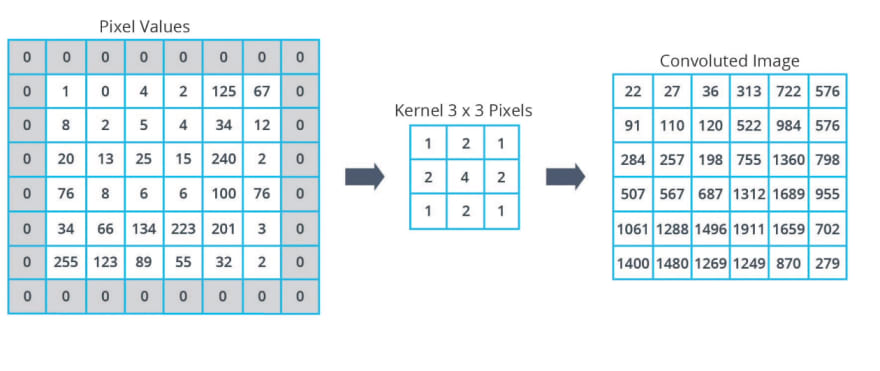

In [276]:
%matplotlib inline
from IPython.display import Image
Image('../../../Downloads/conv.png')

In [338]:
X = np.array([1, 0, 4, 2, 125, 67])
w = np.array([1, 2, 1])

np.convolve(X, w, 'same')

array([  2,   5,  10, 133, 319, 259])

In [340]:
out = np.zeros(compute_output_shape(X.shape, w.shape, 'same'))
for p1, q1, k1 in conviter(X.shape, w.shape, 'same'):
    out[q1] = (X[p1]*w[k1]).sum()

out

array([  2.,   5.,  10., 133., 319., 259.])